In [33]:
# Importing Necessary 
import os
import json
import rasterio
import calendar
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime
from rasterstats import zonal_stats
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SAVED_DATA_PATH="../data/saved/lst.csv"

### Extracting Land Surface Temperature(LST) Dataset

In [3]:
def scene_date_from_filename(fname):
    """Extract scene acquisition date from filename."""
    import re

    m = re.search(r"_(\d{8})_", fname)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d").date()
    return None

In [4]:
def read_band(band_path):
    """Read raster band as float32 array."""
    with rasterio.open(band_path) as src:
        arr = src.read(1).astype("float32")
        profile = src.profile
    return arr, profile

In [5]:
def compute_lst(b10_arr, mult=0.00341802, add=149.0):
    """
    Convert ST_B10 scaled values to LST in Celsius.
    """
    lst_kelvin = b10_arr * mult + add
    lst_c = lst_kelvin - 273.15
    return lst_c

In [6]:
def mean_index_in_aoi(index_arr, profile, aoi_geojson):
    stats = zonal_stats(
        aoi_geojson,
        index_arr,
        affine=profile["transform"],
        stats=["mean", "median", "count", "std"],
        nodata=np.nan,
    )
    return stats[0]

In [7]:
def process_scene_folder_lst(scene_folder, aoi_geojson):
    """
    Process a single scene folder to compute LST statistics over the AOI.
    """
    b10_file = next(p for p in os.listdir(scene_folder) if "_ST_B10" in p)
    b10_arr, prof = read_band(os.path.join(scene_folder, b10_file))

    lst_arr = compute_lst(b10_arr)

    # Reproject AOI to raster CRS
    gdf = gpd.GeoDataFrame.from_features(aoi_geojson["features"], crs="EPSG:4326")
    gdf_utm = gdf.to_crs(prof["crs"])
    aoi_geojson_utm = gdf_utm.__geo_interface__

    stats = mean_index_in_aoi(lst_arr, prof, aoi_geojson_utm)

    scene_date = datetime.strptime(
        b10_file.split("_")[3], "%Y%m%d"
    ).date()  # extract date from filename

    return {
        "date": scene_date,
        "lst_mean": stats["mean"],
        "lst_median": stats["median"],
        "count": stats["count"],
        "lst_std": stats["std"],
    }

In [8]:
def build_timeseries_lst(data_root, aoi_geojson):
    """
    Build LST time series for all scenes in data_root.
    """
    rows = []
    for year in os.listdir(data_root):
        ypath = os.path.join(data_root, year)
        if not os.path.isdir(ypath):
            continue
        for month in os.listdir(ypath):
            mpath = os.path.join(ypath, month)
            if not os.path.isdir(mpath):
                continue
            try:
                r = process_scene_folder_lst(mpath, aoi_geojson)
                rows.append(r)
            except StopIteration:
                continue
    df = pd.DataFrame(rows).dropna().sort_values("date").reset_index(drop=True)
    return df

In [9]:
data_root = "../data"
aoi_geojson_path = "../data/aoi.geojson"

with open(aoi_geojson_path) as f:
    aoi_geojson = json.load(f)

In [10]:
if os.path.exists(SAVED_DATA_PATH):
    # Load from existing CSV
    df = pd.read_csv(SAVED_DATA_PATH)
    print(f"✅ Loaded data from {SAVED_DATA_PATH}")
else:
    # Build timeseries if CSV doesn't exist
    df = build_timeseries_lst(data_root, aoi_geojson)
    df.to_csv(SAVED_DATA_PATH, index=False)
    print(f"✅ Timeseries built and saved to {SAVED_DATA_PATH}")

✅ Loaded data from ../data/saved/lst.csv


### Loading the LST dataset

In [11]:
df = pd.read_csv(SAVED_DATA_PATH)
df.head()

,date,lst_mean,lst_median,count,lst_std
0,2022-01-27,12.678693,13.473175,2649889,4.144818
1,2022-02-12,13.168478,13.626984,2649889,4.372898
2,2022-03-08,25.446898,25.754120,2649889,3.893588
3,2022-04-17,31.615350,32.005646,2649889,4.400812
4,2022-05-27,27.281529,27.921112,2649889,4.171977


In [27]:
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["month"].apply(lambda x: calendar.month_name[x])

### Basic Stats & Info

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        24 non-null     datetime64[ns]
 1   lst_mean    24 non-null     float64       
 2   lst_median  24 non-null     float64       
 3   count       24 non-null     int64         
 4   lst_std     24 non-null     float64       
 5   year        24 non-null     int32         
 6   month       24 non-null     object        
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(1)
memory usage: 1.3+ KB


In [29]:
df[["lst_median", "lst_mean", "lst_std"]].describe()

,lst_median,lst_mean,lst_std
count,24.000000,24.000000,24.000000
mean,23.074668,22.346882,4.738498
std,6.596723,6.288520,1.979375
min,13.473175,12.678693,3.314992
25%,17.918304,17.168214,3.699574
50%,22.119049,21.652286,4.158397
75%,27.423798,26.954174,4.633437
max,36.486694,35.684227,12.096729


In [30]:
df['year'].value_counts()

year
2023    9
2022    8
2024    7
Name: count, dtype: int64

In [31]:
df['month'].value_counts()

month
February    3
October     3
March       3
April       3
May         3
December    3
November    3
January     2
June        1
Name: count, dtype: int64

### Time Series Plot

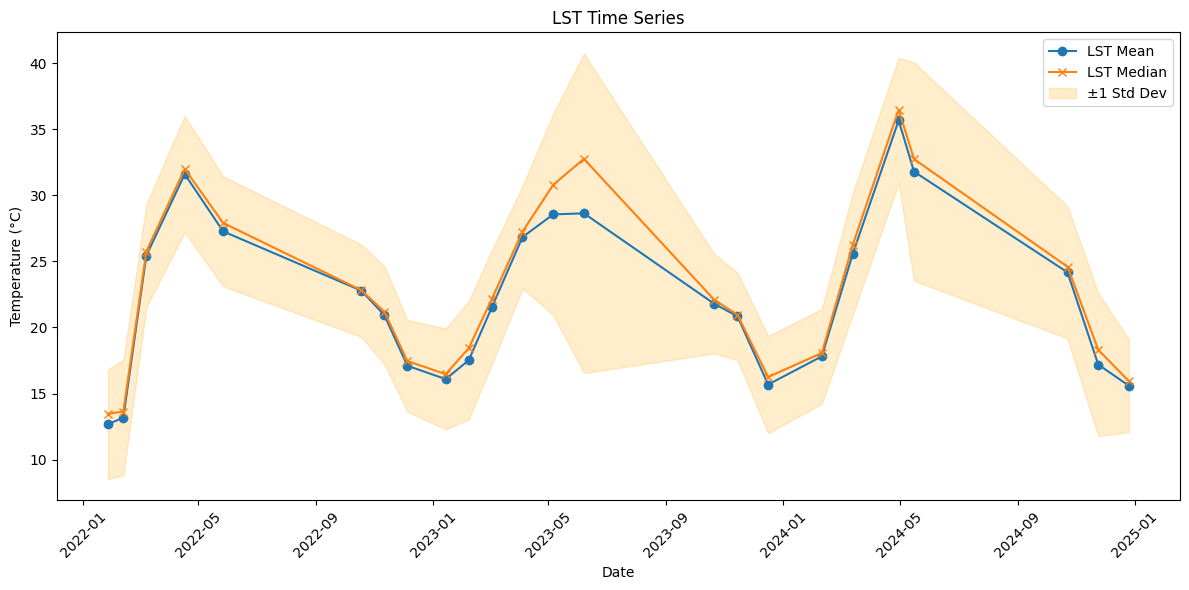

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["lst_mean"], marker="o", label="LST Mean")
plt.plot(df["date"], df["lst_median"], marker="x", label="LST Median")
plt.fill_between(
    df["date"],
    df["lst_mean"] - df["lst_std"],
    df["lst_mean"] + df["lst_std"],
    alpha=0.2,
    color="orange",
    label="±1 Std Dev",
)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("LST Time Series")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### Seasonal Decomposition

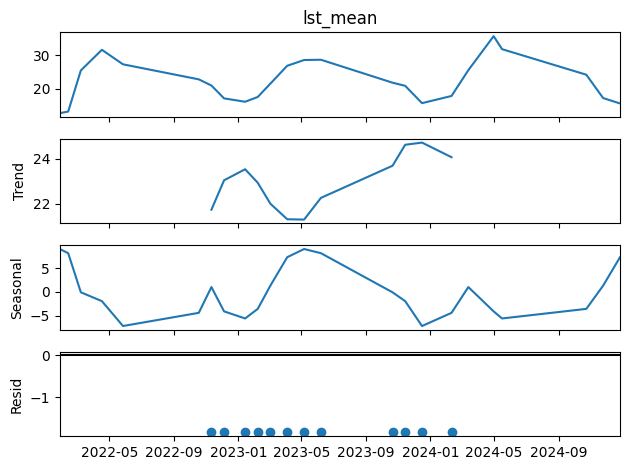

In [34]:
df.set_index("date", inplace=True)
result = seasonal_decompose(
    df["lst_mean"], model="additive", period=12
)  # assuming roughly monthly data
result.plot()
plt.show()

### Rolling Mean (Smoothing)

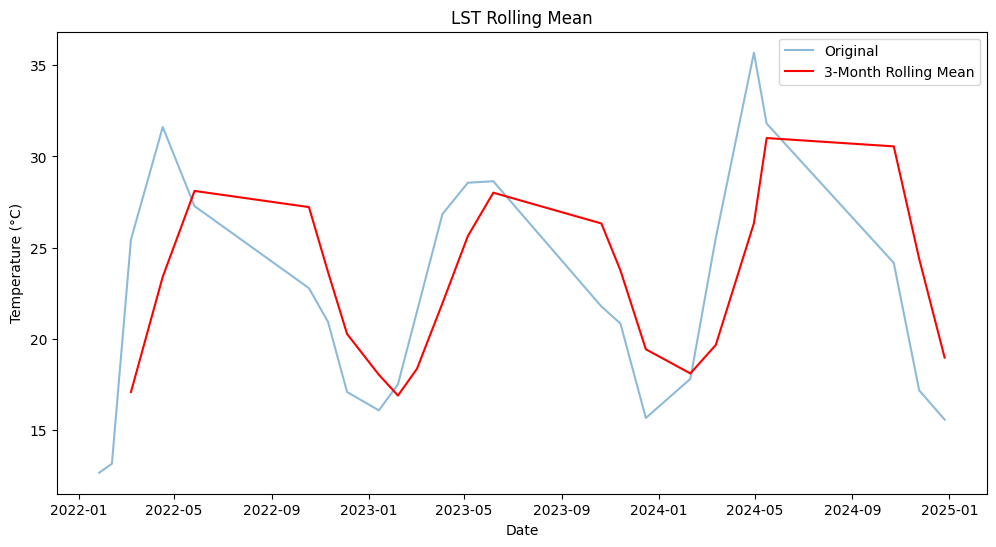

In [35]:
df["lst_mean_rolling"] = df["lst_mean"].rolling(window=3).mean()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["lst_mean"], label="Original", alpha=0.5)
plt.plot(df.index, df["lst_mean_rolling"], label="3-Month Rolling Mean", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("LST Rolling Mean")
plt.legend()
plt.show()

### LST Growth/Change

In [36]:
df["lst_change"] = df["lst_mean"].diff()  # absolute change
df["lst_change_pct"] = df["lst_mean"].pct_change() * 100  # percentage change

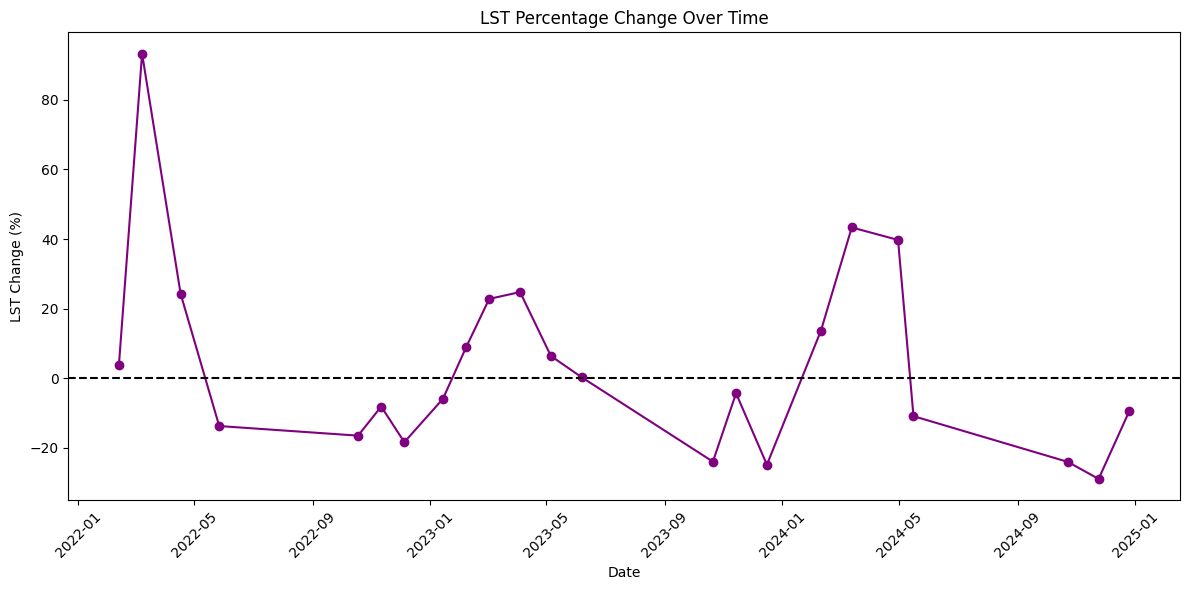

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["lst_change_pct"], marker="o", color="purple")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Date")
plt.ylabel("LST Change (%)")
plt.title("LST Percentage Change Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Overall LST Change

In [38]:
lst_start = df["lst_mean"].iloc[0]
lst_end = df["lst_mean"].iloc[-1]
overall_change_pct = ((lst_end - lst_start) / lst_start) * 100
print(f"Overall LST change: {overall_change_pct:.2f}%")

Overall LST change: 22.96%


### Yearly Average

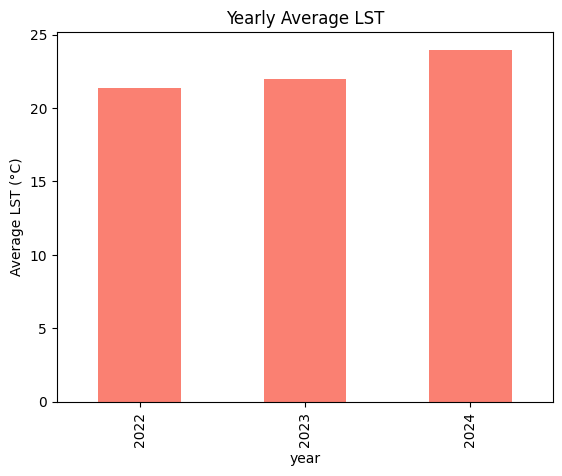

In [39]:
df["year"] = df.index.year
yearly_avg = df.groupby("year")["lst_mean"].mean()
yearly_avg.plot(kind="bar", color="salmon")
plt.ylabel("Average LST (°C)")
plt.title("Yearly Average LST")
plt.show()

### Heatmap of monthly mean LST across years

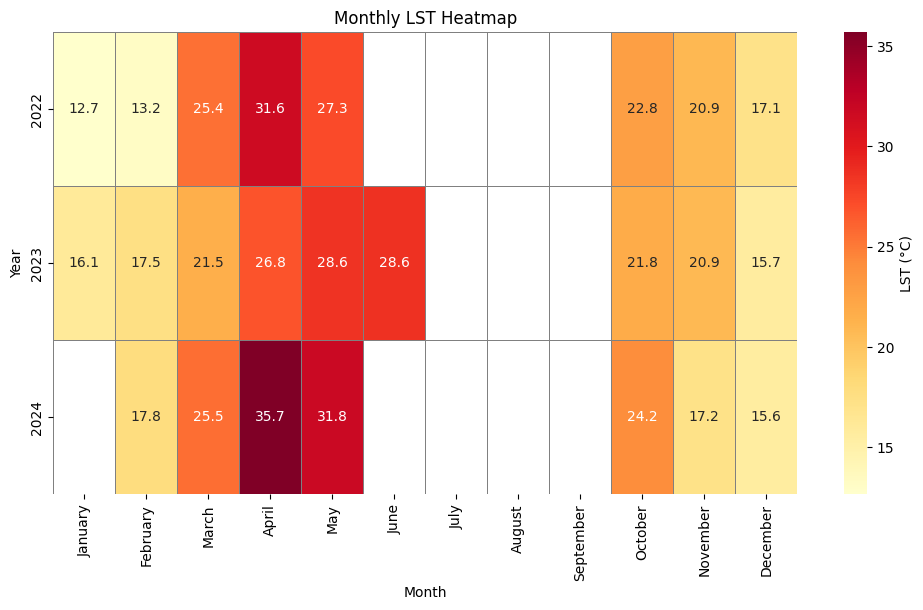

In [44]:
# Pivot table (assuming 'month_name' column exists)
heatmap_df = df.pivot_table(index="year", columns="month", values="lst_mean")

# Define correct chronological order
months_order = list(calendar.month_name[1:])  # ['January', 'February', ... 'December']

# Reindex columns to follow chronological order
heatmap_df = heatmap_df.reindex(columns=months_order)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar_kws={"label": "LST (°C)"},
    linewidths=0.5,
    linecolor="gray",
)
plt.title("Monthly LST Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()